# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt



# Loading and Preprocessing Data
Load the dataset and preprocess it by dropping non-relevant columns. Apply Isolation Forest for outlier detection and removal.


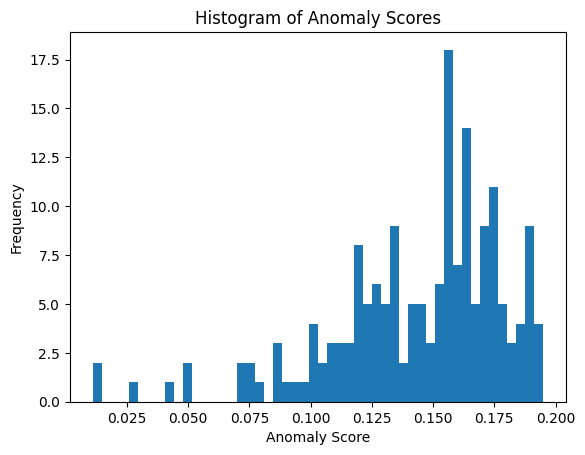

Proportion of observations considered as outliers based on the chosen contamination level: 0.05142857142857143


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Assuming 'aggregated_plants.csv' is your dataset and it's in the correct path
df = pd.read_csv('aggregated_plants.csv')

# Dropping non-relevant columns
df = df.drop(columns=['Plant_Species', 'Reference', 'BitInterpretations'])

# Separating features and target
# Ensure 'Salmonella Typhimurium' is indeed a column and not meant to be the target for IsolationForest which is unsupervised
features = df.drop('Salmonella Typhimurium', axis=1)
target = df['Salmonella Typhimurium']  # This line might not be necessary if you're not using 'target' later

# Fit the model
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(features)

# Compute the anomaly scores (the lower, the more abnormal)
scores = iso_forest.decision_function(features)

# Plot histogram of scores 
plt.hist(scores, bins=50)
plt.title('Histogram of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

# Save the figure BEFORE calling plt.show()
plt.savefig('charts/anomaly_scores.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Determine the contamination level based on the anomaly scores
contamination_level = np.percentile(scores, 5)

# Calculate the proportion of observations considered as outliers
outlier_proportion = np.mean(scores < contamination_level)

print(f"Proportion of observations considered as outliers based on the chosen contamination level: {outlier_proportion}")


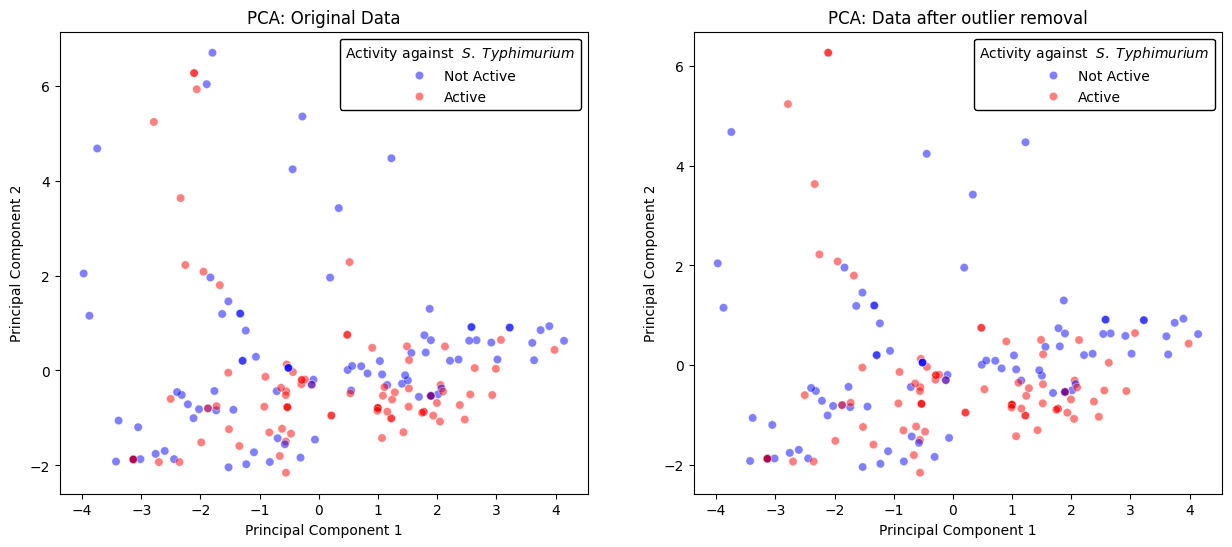

In [4]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


# Load the dataset
df = pd.read_csv('aggregated_plants.csv')

# Dropping non-relevant columns
df = df.drop(columns=['Plant_Species', 'Reference', 'BitInterpretations'])

# Separating features and target
features = df.drop('Salmonella Typhimurium', axis=1)
target = df['Salmonella Typhimurium']

# Apply PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# Apply Isolation Forest on original features to detect outliers
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers_pred = iso_forest.fit_predict(features)

# Filter out the outliers based on predictions
features_filtered = features[outliers_pred != -1]
target_filtered = target[outliers_pred != -1]

# Apply PCA on filtered features for visualization
features_filtered_pca = pca.transform(features_filtered)

# Mapping target values to 'Active' and 'Not Active'
activity_labels = pd.Series(target).map({1: 'Active', 0: 'Not Active'}).values
activity_labels_filtered = pd.Series(target_filtered).map({1: 'Active', 0: 'Not Active'}).values

# Plotting
plt.figure(figsize=(15, 6))

# Original Data
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=activity_labels,
                alpha=0.5, palette={'Active': 'red', 'Not Active': 'blue'})
plt.title('PCA: Original Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend = ax1.legend(title="Activity against  $\it{S.\ Typhimurium}$", frameon=True, facecolor='white')
legend.get_frame().set_alpha(None)
legend.get_frame().set_edgecolor('black')

# Data After Outlier Removal
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(x=features_filtered_pca[:, 0], y=features_filtered_pca[:, 1], hue=activity_labels_filtered,
                alpha=0.5, palette={'Active': 'red', 'Not Active': 'blue'})
plt.title('PCA: Data after outlier removal')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend = ax2.legend(title="Activity against  $\it{S.\ Typhimurium}$", frameon=True, facecolor='white')
legend.get_frame().set_alpha(None)
legend.get_frame().set_edgecolor('black')

# Save the figure
plt.savefig('charts/outlier_detection_result.png', dpi=300, bbox_inches='tight')

plt.show()



# Feature Selection
Use GridSearchCV to find the best parameters for the ExtraTreesClassifier and train the model.


In [58]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, make_scorer, matthews_corrcoef
import numpy as np

# features_filtered and target_filtered are defined and preprocessed

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_filtered, target_filtered, test_size=0.2, random_state=42)

# Defining the model
model = ExtraTreesClassifier(random_state=42)

# Defining the parameter grid
param_grid = {
    'n_estimators': [50, 60, 70, 80, 90, 100],  
    'max_features': np.arange(0.1, 1.1, 0.1).tolist() +['sqrt', 'log2'],  
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}
# Creating a scorer from matthews_corrcoef which is considering all four quadrants of the confusion matrix
mcc_scorer = make_scorer(matthews_corrcoef)


# Setting up the grid search with cross-validation and MCC as the scoring method
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=mcc_scorer, cv=5, verbose=0, n_jobs=-1)

# Fitting the grid search to the data
grid_search.fit(X_train, y_train)

# Outputting the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Predicting on the test set with the best model
y_pred = grid_search.predict(X_test)

# Outputting the classification report
print(classification_report(y_test, y_pred))

# Calculating and printing the MCC for the test set
mcc_score = matthews_corrcoef(y_test, y_pred)
print("MCC on test set: ", mcc_score)


Best parameters found:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 0.7000000000000001, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 90}
              precision    recall  f1-score   support

           0       0.68      0.79      0.73        19
           1       0.67      0.53      0.59        15

    accuracy                           0.68        34
   macro avg       0.67      0.66      0.66        34
weighted avg       0.68      0.68      0.67        34

MCC on test set:  0.3354002900991854


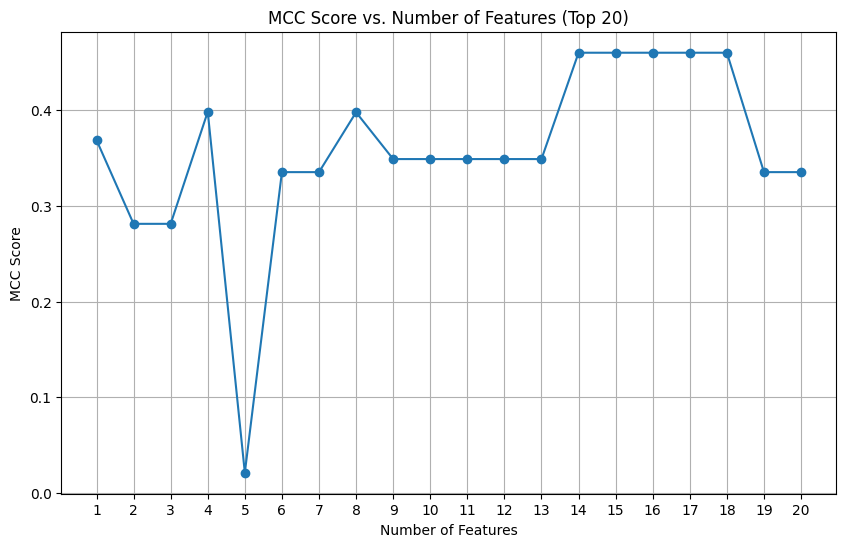

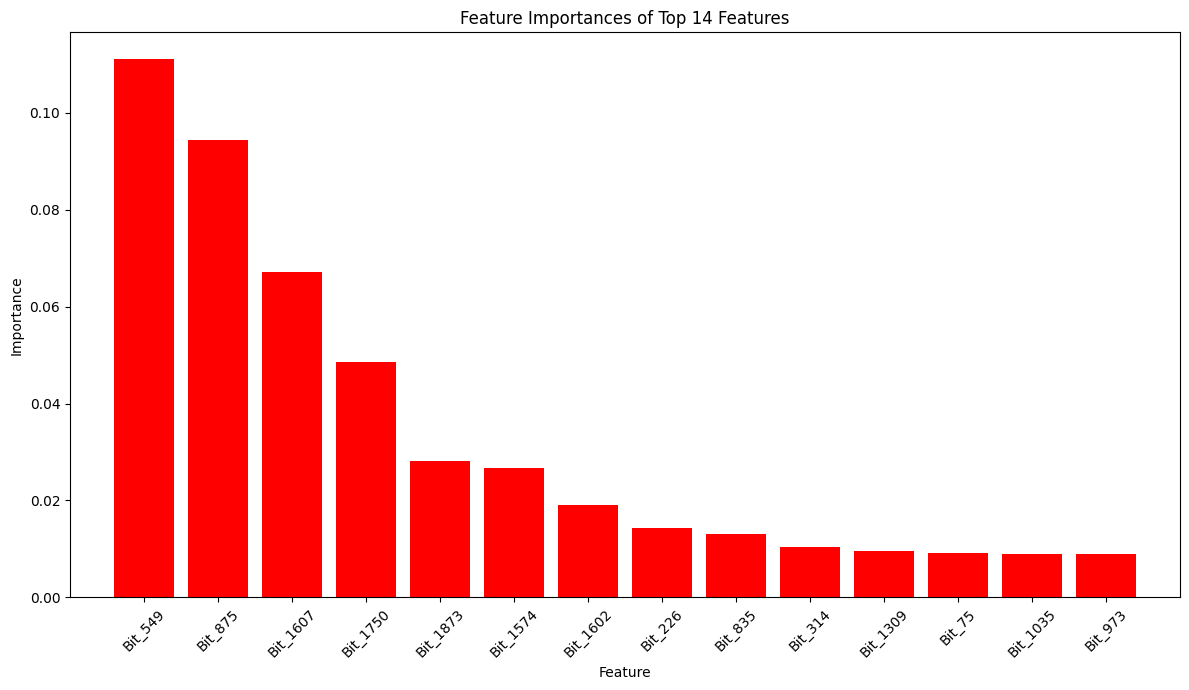

Top 14 Features and their Importances:
Bit_549: 0.11102734951804005
Bit_875: 0.09436665600468262
Bit_1607: 0.06711078516145043
Bit_1750: 0.04861364148813559
Bit_1873: 0.02817733836908371
Bit_1574: 0.026782113715756634
Bit_1602: 0.01912217735887144
Bit_226: 0.014312089997607339
Bit_835: 0.013035404834245425
Bit_314: 0.010394241945296161
Bit_1309: 0.009673576801716367
Bit_75: 0.00916239475907731
Bit_1035: 0.008902921452483642
Bit_973: 0.008891882178908071


In [71]:
import matplotlib.pyplot as plt
import numpy as np 

# X_train, X_test, y_train, y_test are previously defined DataFrames/Series

# Extracting the best model
best_model = grid_search.best_estimator_

# Getting the feature importances
importances = best_model.feature_importances_

# Sorting the feature importances in descending order and keeping track of the indices
indices = np.argsort(importances)[::-1]

# Considering only the top 20 features for initial MCC score calculation
top_20_indices = indices[:20]

# Initialize lists to store MCC scores and the corresponding number of features
mcc_scores = []
feature_counts = []

for i in range(1, len(top_20_indices) + 1):
    # Selecting the features based on current iteration
    selected_features = X_train.columns[top_20_indices[:i]]
    
    # Training the model on the selected features
    temp_model = ExtraTreesClassifier(random_state=42, **grid_search.best_params_)
    temp_model.fit(X_train[selected_features], y_train)
    
    # Predicting on the test set with the selected features
    y_pred_temp = temp_model.predict(X_test[selected_features])
    
    # Calculating MCC for the current number of features
    mcc_score_temp = matthews_corrcoef(y_test, y_pred_temp)
    mcc_scores.append(mcc_score_temp)
    feature_counts.append(i)

# Plotting the MCC scores against the number of features used
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, mcc_scores, marker='o')
plt.title('MCC Score vs. Number of Features (Top 20)')
plt.xlabel('Number of Features')
plt.ylabel('MCC Score')
plt.xticks(np.arange(1, len(top_20_indices) + 1, 1))  # Setting x-axis to show each whole number
plt.grid(True)
plt.show()

# Now focusing on the top 14 features as identified to be optimal
# Adjusting indices to focus on top 14 for visualization
indices = indices[:14]

# Plotting the importances of these top 14 features
plt.figure(figsize=(12, 7))
plt.title('Feature Importances of Top 14 Features')
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), X_train.columns[indices], rotation=45)
plt.xlim([-1, len(indices)])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Printing the top 14 features and their importances
print("Top 14 Features and their Importances:")
for i in indices:
    print(f"{X_train.columns[i]}: {importances[i]}")


In [86]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef, classification_report
import numpy as np

#the indices of the top features
top_indices = np.argsort(best_model.feature_importances_)[::-1][:14]

# Redefining the dataset to include only the top features
X_train_top = X_train.iloc[:, top_indices]
X_test_top = X_test.iloc[:, top_indices]

# Defining the model
model_top = ExtraTreesClassifier(random_state=42)

#optimizing parametrs for the new model with top features
param_grid_top = {
    'n_estimators': [20, 25, 30, 35],
    'max_features': np.arange(0.1, 1.1, 0.1).tolist()+['sqrt', 'log2'],
    'max_depth': [8, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False], 
    'criterion': ['gini', 'entropy']  
}

# Creating a scorer from matthews_corrcoef
mcc_scorer_top = make_scorer(matthews_corrcoef)

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Setting up the grid search with cross-validation and MCC aas the scoring method
grid_search_top = GridSearchCV(estimator=model_top, param_grid=param_grid_top, scoring=mcc_scorer_top, cv=skf, verbose=0, n_jobs=-1)

# Fitting the grid search to the data
grid_search_top.fit(X_train_top, y_train)

# Outputting the best parameters
print("Best parameters found with top features: ", grid_search_top.best_params_)

# Predicting on the test set with the best model
y_pred_top = grid_search_top.predict(X_test_top)

# Outputting the classification report
print(classification_report(y_test, y_pred_top))

# Calculating and printing the MCC for the test set
mcc_score_top = matthews_corrcoef(y_test, y_pred_top)
print("MCC on test set with top features: ", mcc_score_top)


Best parameters found with top features:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 8, 'max_features': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 25}
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        19
           1       0.77      0.67      0.71        15

    accuracy                           0.76        34
   macro avg       0.77      0.75      0.76        34
weighted avg       0.77      0.76      0.76        34

MCC on test set with top features:  0.5198334821596409


In [87]:
from sklearn.metrics import confusion_matrix, accuracy_score

def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics = {
        "accuracy": "{:.2f}".format((tp + tn) / (tp + tn + fp + fn)),
        "sensitivity": "{:.2f}".format(tp / (tp + fn)) if (tp + fn) != 0 else "0.00",
        "specificity": "{:.2f}".format(tn / (tn + fp)) if (tn + fp) != 0 else "0.00",
        "ppv": "{:.2f}".format(tp / (tp + fp)) if (tp + fp) != 0 else "0.00",
        "npv": "{:.2f}".format(tn / (tn + fn)) if (tn + fn) != 0 else "0.00",
    }
    return metrics

# Predict on training data to calculate training metrics
y_train_pred_top = grid_search_top.predict(X_train_top)

# Calculate training metrics
train_metrics = calculate_metrics(y_train, y_train_pred_top)

# Calculate test metrics
test_metrics = calculate_metrics(y_test, y_pred_top)

# Initialize the metrics dictionary to store metrics for the best model
metrics = {
    "train_accuracy": train_metrics["accuracy"],
    "train_sensitivity": train_metrics["sensitivity"],
    "train_specificity": train_metrics["specificity"],
    "train_ppv": train_metrics["ppv"],
    "train_npv": train_metrics["npv"],
    "test_accuracy": test_metrics["accuracy"],
    "test_sensitivity": test_metrics["sensitivity"],
    "test_specificity": test_metrics["specificity"],
    "test_ppv": test_metrics["ppv"],
    "test_npv": test_metrics["npv"],
}

# Print the metrics for both training and test sets
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")


train_accuracy: 0.86
train_sensitivity: 0.87
train_specificity: 0.84
train_ppv: 0.86
train_npv: 0.85
test_accuracy: 0.76
test_sensitivity: 0.67
test_specificity: 0.84
test_ppv: 0.77
test_npv: 0.76


# Learning Curve Visualization
Plot the learning curve to visualize the model's performance over various training set sizes.


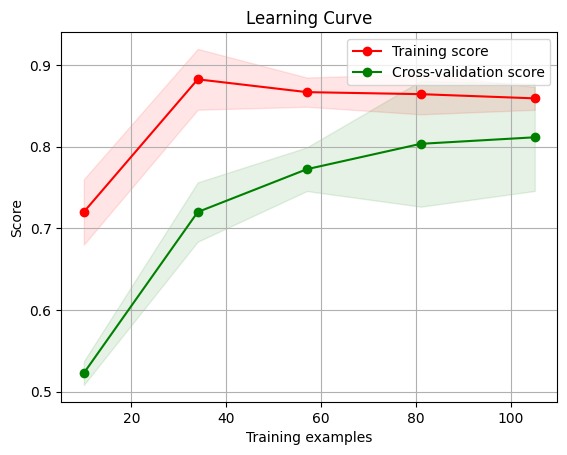

In [90]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Extract the best model from grid search
best_model_top = grid_search_top.best_estimator_

# Determine the training and test sizes and scores to plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model_top, 
    X_train_top, 
    y_train, 
    cv=5,
    scoring='accuracy', 
    n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 5)
)

# Calculate the mean and standard deviation for training and test set scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot the standard deviation for the training set
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")

# Plot the standard deviation for the cross-validation set
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")

plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")

plt.show()


# ROC Curve, Precision-Recall Curve


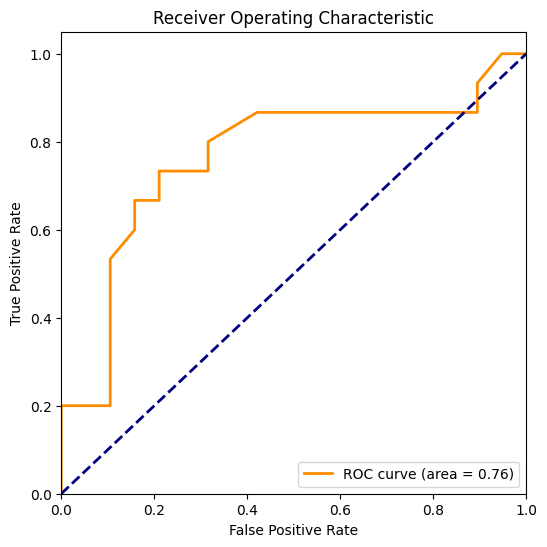

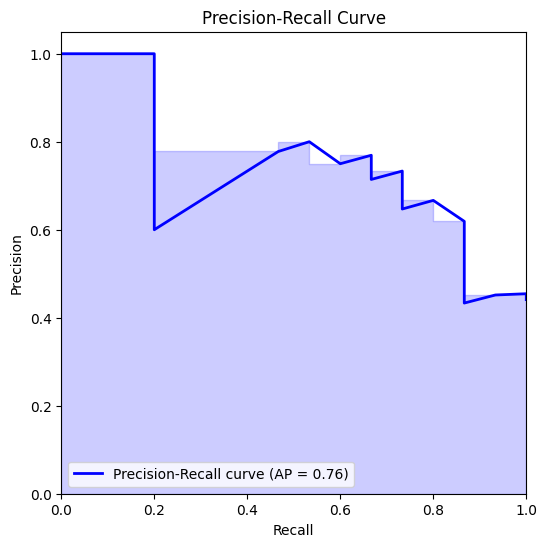

ROC curve saved to: charts/roc_curve.png
Precision-Recall curve saved to: charts/pr_curve.png


In [93]:
import os

# Ensure the charts directory exists
os.makedirs('charts', exist_ok=True)

# Predict probabilities for the test set
y_scores_top = grid_search_top.predict_proba(X_test_top)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores_top)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Display the ROC Curve
plt.show()

# Save the ROC Curve
roc_curve_path = 'charts/roc_curve.png'
plt.savefig(roc_curve_path, dpi=300)
plt.close()  # Close the plot to clear the current figure

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores_top)
average_precision = average_precision_score(y_test, y_scores_top)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Display the Precision-Recall Curve
plt.show()

# Save the Precision-Recall Curve
pr_curve_path = 'charts/pr_curve.png'
plt.savefig(pr_curve_path, dpi=300)
plt.close()  # Close the plot to clear the current figure

# Output paths of the saved plots
print(f"ROC curve saved to: {roc_curve_path}")
print(f"Precision-Recall curve saved to: {pr_curve_path}")


# PDP plots

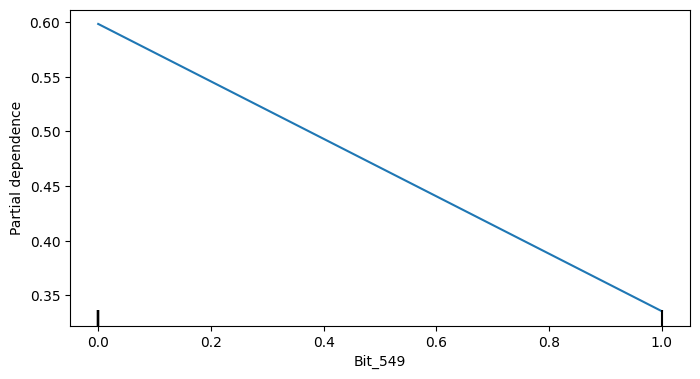

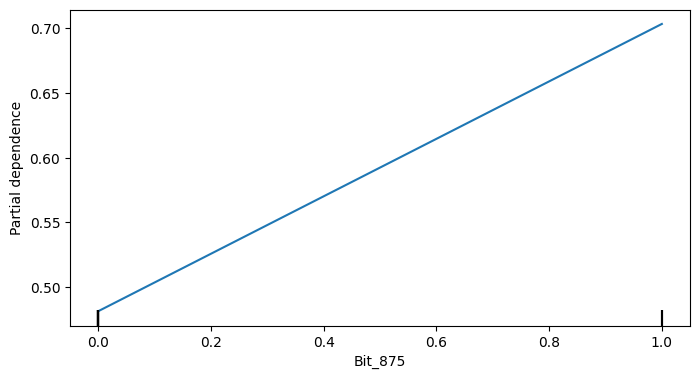

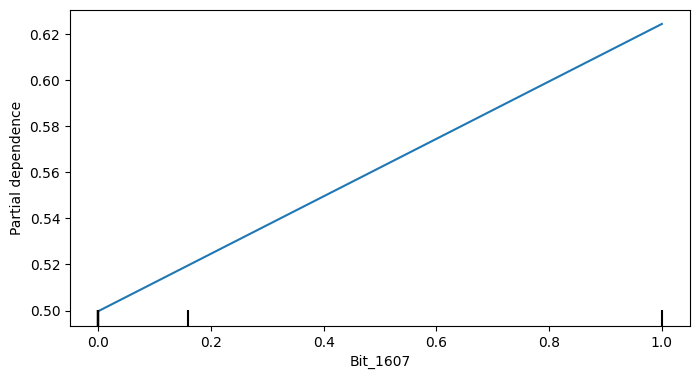

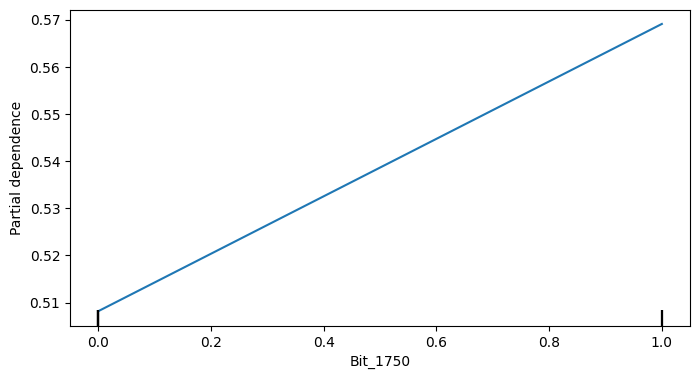

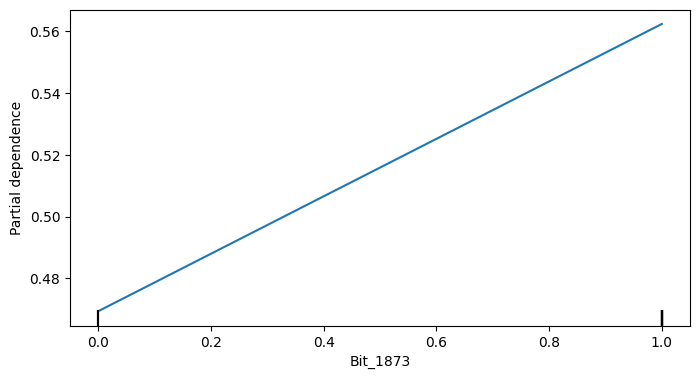

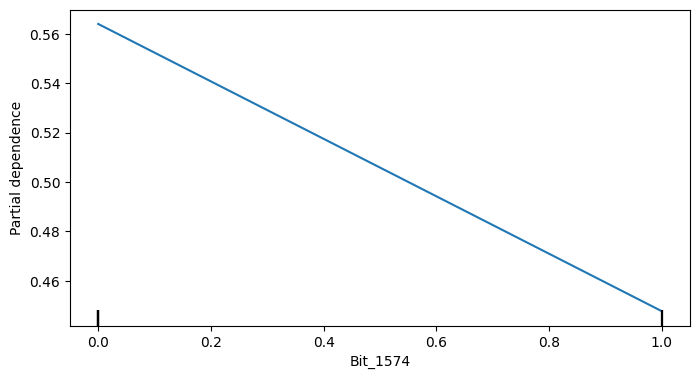

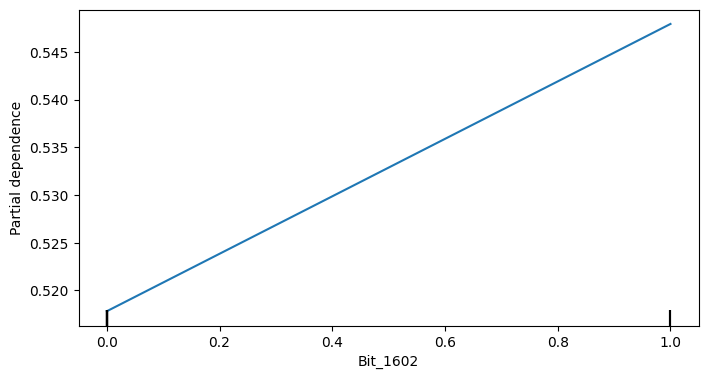

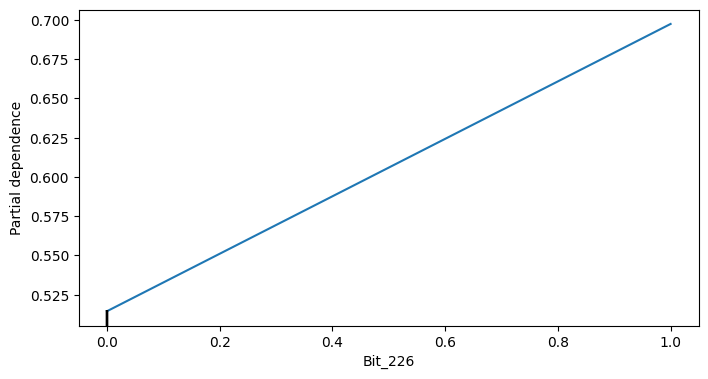

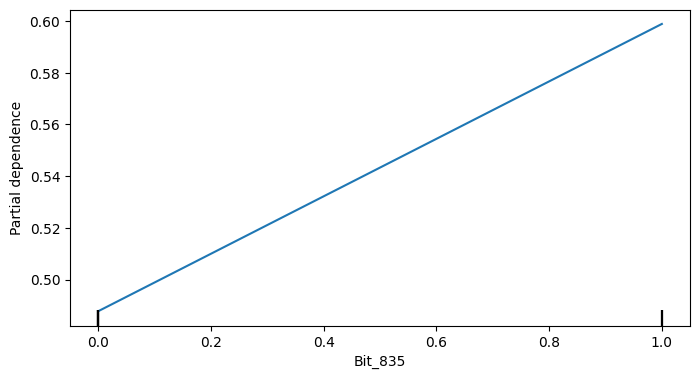

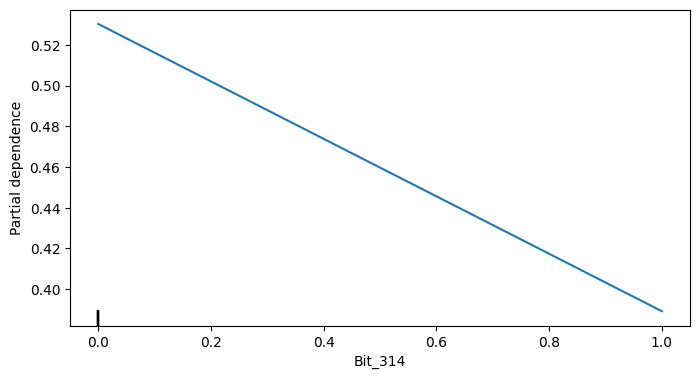

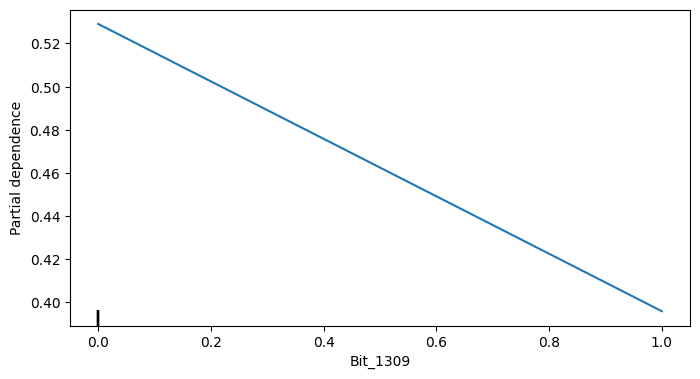

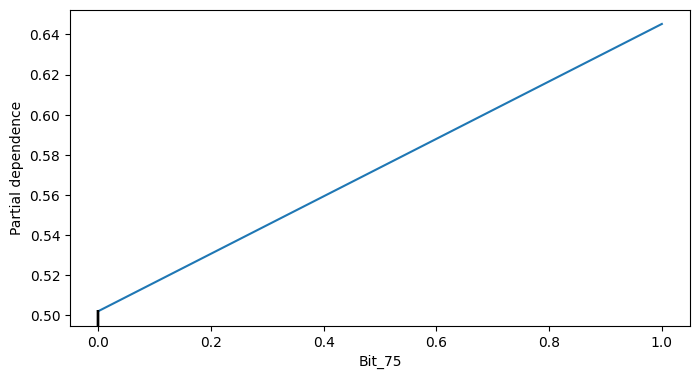

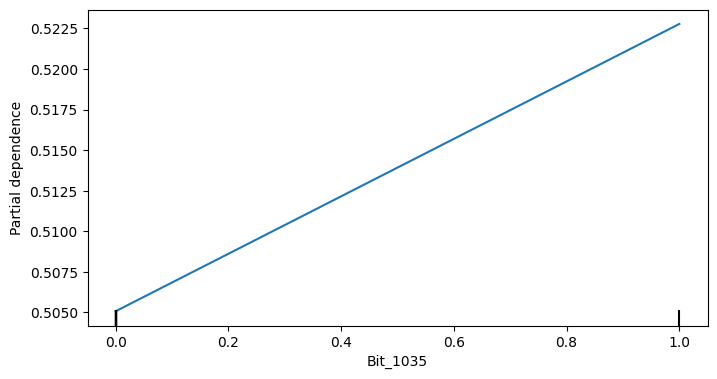

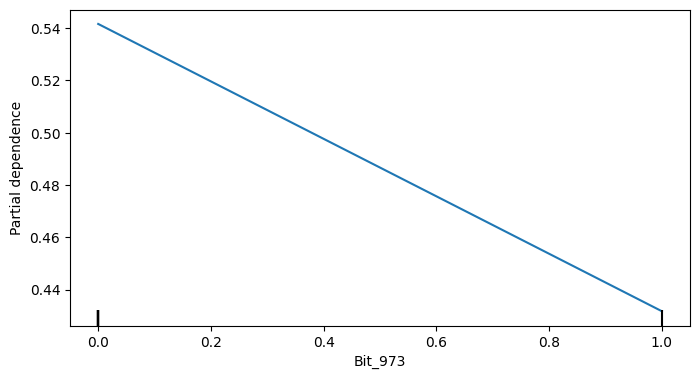

All partial dependence plots have been saved in the 'pdp' directory.


In [95]:
import os
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Ensure the pdp directory exists
os.makedirs('pdp', exist_ok=True)

# Assuming X_train_top is your dataset with top features
for feature_index in range(X_train_top.shape[1]):
    fig, ax = plt.subplots(figsize=(8, 4))
    display = PartialDependenceDisplay.from_estimator(
        best_model_top,
        X_train_top,
        features=[feature_index],
        ax=ax,
        kind="average"
    )
    plt.subplots_adjust(top=0.9)  # Adjust layout to fit suptitle
    
    # Save the plot to the 'pdp' directory with 300 dpi resolution
    plot_path = f'pdp/pdp_feature_{feature_index}.png'
    plt.savefig(plot_path, dpi=300)
    plt.show()
    plt.close()  

print("All partial dependence plots have been saved in the 'pdp' directory.")


# PDP plots

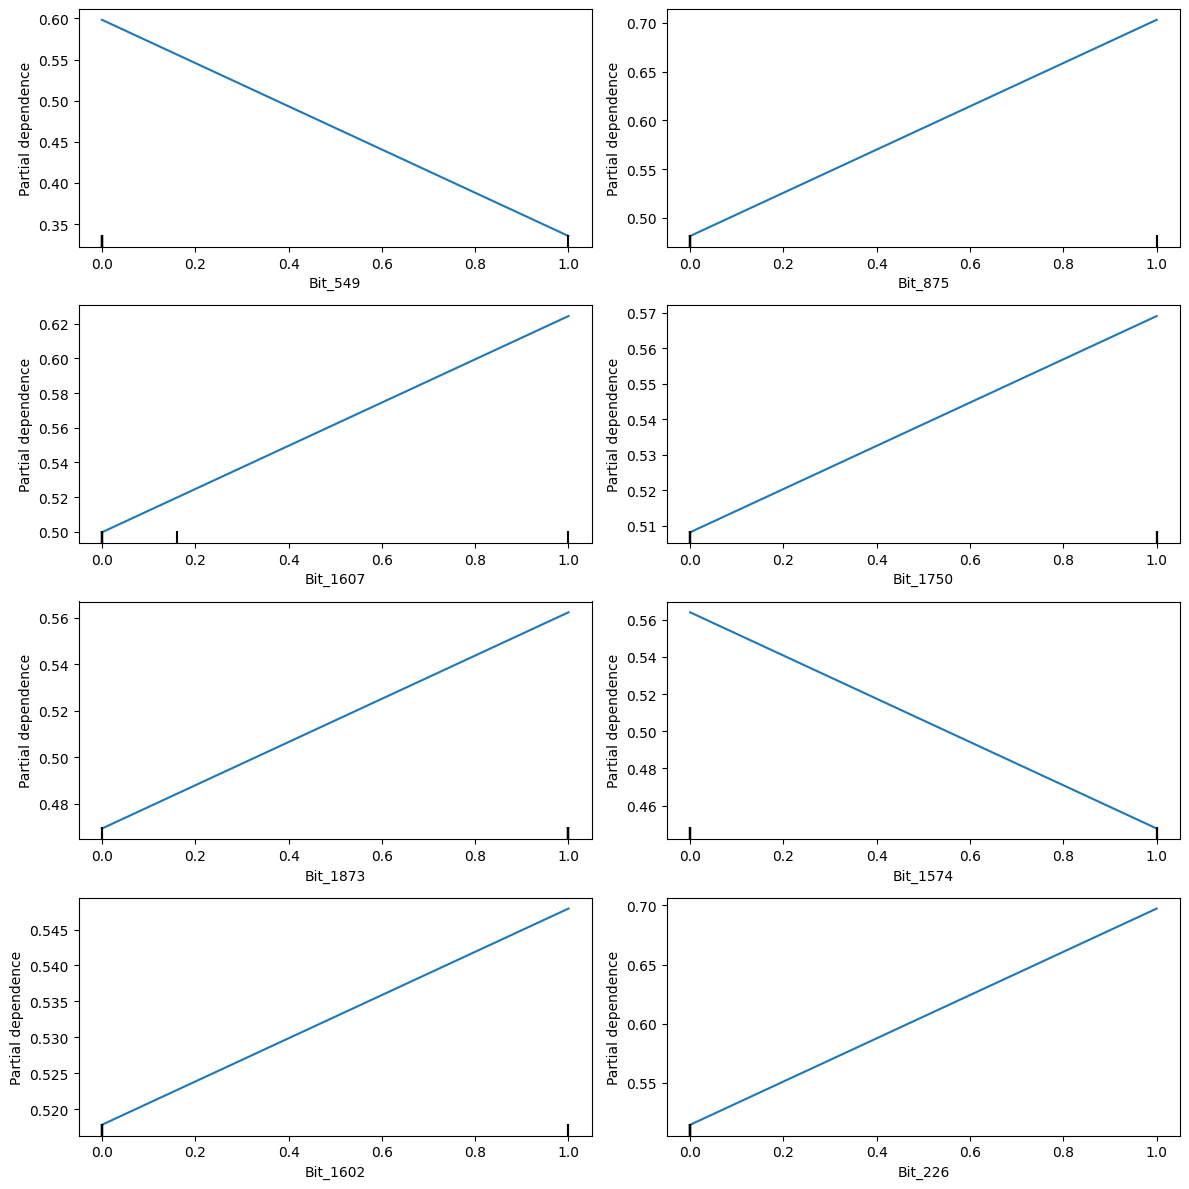

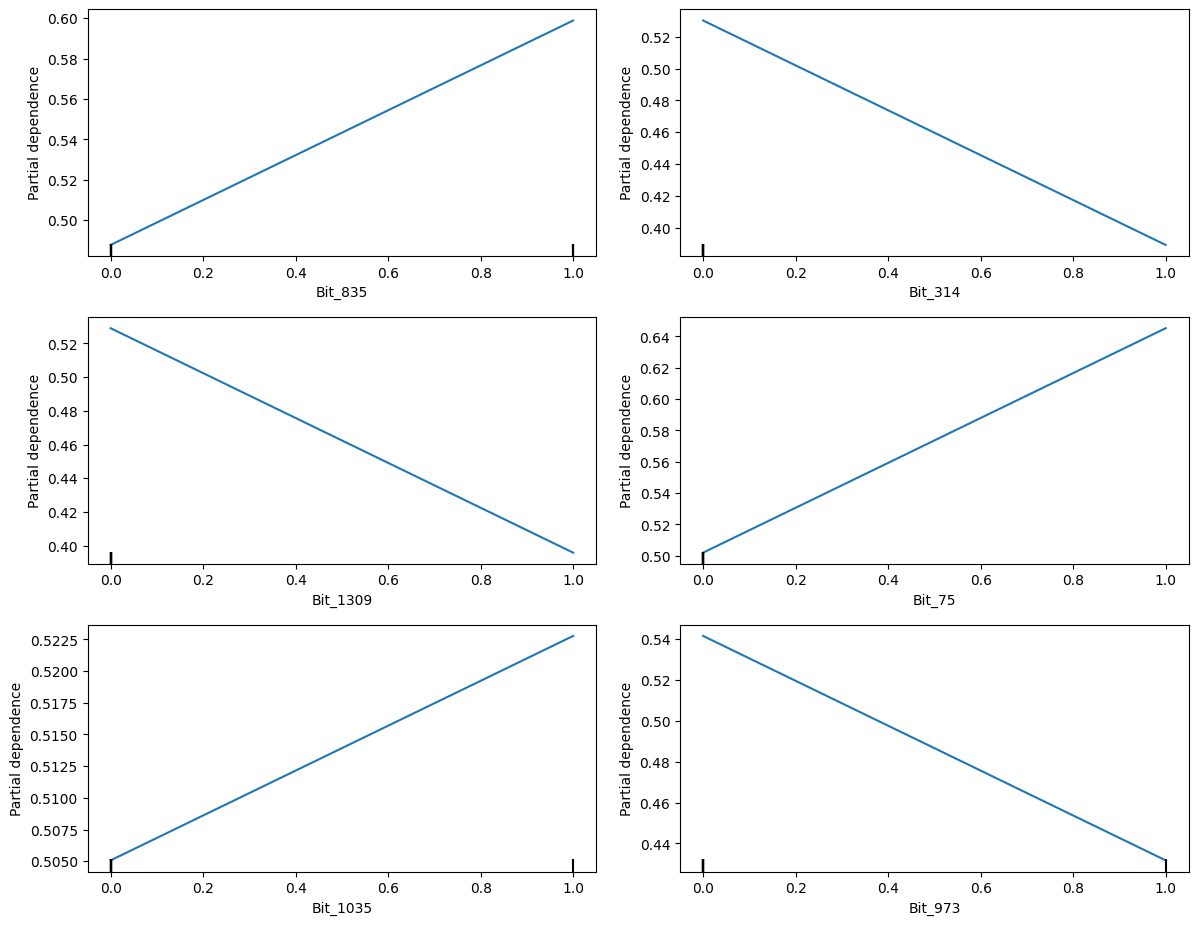

All PDP collages have been saved in the 'pdp' directory.


In [96]:
def create_pdp_collage(start_feature, end_feature, n_rows, n_cols, file_name):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*3))  # Adjust figure size as necessary
    axs = axs.flatten()
    
    for idx, feature_index in enumerate(range(start_feature, end_feature)):
        PartialDependenceDisplay.from_estimator(
            best_model_top,
            X_train_top,
            features=[feature_index],
            ax=axs[idx],
            kind="average"
        )
    
    # Hide any unused subplots
    for ax in axs[end_feature - start_feature:]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.savefig(f'pdp/{file_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Total number of features in X_train_top
total_features = X_train_top.shape[1]

# Adjust these values based on how many features you want per collage
n_rows = 4
n_cols = 2
features_per_collage = n_rows * n_cols

# Calculate how many collages are needed
num_collages = (total_features + features_per_collage - 1) // features_per_collage

# Generate each collage
for i in range(num_collages):
    start_feature = i * features_per_collage
    end_feature = min((i + 1) * features_per_collage, total_features)
    create_pdp_collage(start_feature, end_feature, n_rows, n_cols, f'pdp_collage_{i+1}')

print("All PDP collages have been saved in the 'pdp' directory.")


# the following yet to be modified

https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets

# Inspecting Features

In [30]:
import pandas as pd
import os

# Load the data
file_path = 'aggregated_plants.csv'
df = pd.read_csv(file_path)

# List of important features from the model 
important_features = [
    'Bit_875',
    'Bit_549',
    'Bit_1607',
    'Bit_383',
    'Bit_1602',
    'Bit_1750',
    'Bit_1365',
    'Bit_1930',
    'Bit_1853',
    'Bit_1950',
    'Bit_171',
    'Bit_741',
    'Bit_1574',
    'Bit_1309'
]



save_dir = './features/' 

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Iterating through each important feature
for feature in important_features:
    # Filter rows where the feature is present (1)
    feature_present_df = df[df[feature] == 1]
    
    # Drop all other 'Bit_' columns except the one in focus
    columns_to_drop = [col for col in df.columns if col.startswith('Bit_') and col != feature]
    feature_present_df = feature_present_df.drop(columns=columns_to_drop)
    
    # Define the new file path
    new_file_path = save_dir + f"{feature}.csv"
    
    # Save the filtered rows to a new CSV file
    feature_present_df.to_csv(new_file_path, index=False)
    
    print(f"Rows where {feature} is present and all other Bit_ columns are removed have been saved to '{new_file_path}'")


Rows where Bit_875 is present and all other Bit_ columns are removed have been saved to './features/Bit_875.csv'
Rows where Bit_549 is present and all other Bit_ columns are removed have been saved to './features/Bit_549.csv'
Rows where Bit_1607 is present and all other Bit_ columns are removed have been saved to './features/Bit_1607.csv'
Rows where Bit_383 is present and all other Bit_ columns are removed have been saved to './features/Bit_383.csv'
Rows where Bit_1602 is present and all other Bit_ columns are removed have been saved to './features/Bit_1602.csv'
Rows where Bit_1750 is present and all other Bit_ columns are removed have been saved to './features/Bit_1750.csv'
Rows where Bit_1365 is present and all other Bit_ columns are removed have been saved to './features/Bit_1365.csv'
Rows where Bit_1930 is present and all other Bit_ columns are removed have been saved to './features/Bit_1930.csv'
Rows where Bit_1853 is present and all other Bit_ columns are removed have been saved 

# Adding SMILES-Chemical pairs, Chemical names, and Concentrations


In [31]:
import pandas as pd
import os
import ast
from collections import Counter
import glob

def safe_literal_eval(s):
    dict_strings = [d.strip() for d in s.split(';') if d.strip()]
    all_dicts = {}
    for dict_str in dict_strings:
        try:
            all_dicts.update(ast.literal_eval(dict_str))
        except Exception as e:
            print(f"Failed to parse part: {dict_str}\nError: {e}")
    return all_dicts

def preprocess_bit_name(bit_name):
    bit_number = bit_name.replace('Bit_', '').replace('.csv', '')
    return int(bit_number)

features_dir = 'features/'
reorganized_plants_path = 'reorganized_plants_filtered.csv'
combined_chemicals_path = '../initial_data/combined_chemicals_smiles.csv'

reorganized_plants_df = pd.read_csv(reorganized_plants_path)
combined_chemicals_df = pd.read_csv(combined_chemicals_path)  # Load the combined chemicals data
reorganized_plants_df = reorganized_plants_df.drop_duplicates(subset=['Plant_Species', 'Chemical'])

assert 'Concentration' in reorganized_plants_df.columns, "Concentration column not found in the reorganized plants data!"

bit_files = glob.glob(os.path.join(features_dir, 'Bit_*.csv'))

for bit_file in bit_files:
    bit_name = os.path.basename(bit_file)
    bit_name = bit_name.replace('.csv', '')

    new_bit_file = os.path.join(features_dir, f"{bit_name}_updated.csv")

    bit_df = pd.read_csv(bit_file)

    bit_df['BitInterpretations'] = bit_df['BitInterpretations'].apply(safe_literal_eval)

    if 'SMILES' not in bit_df.columns:
        bit_df.insert(3, 'SMILES', '')
    if 'Chemical' not in bit_df.columns:
        bit_df.insert(4, 'Chemical', '')
    if 'Chemical_name' not in bit_df.columns:  # Add Chemical_name column 
        bit_df.insert(5, 'Chemical_name', '')

    expanded_rows = []

    for index, row in bit_df.iterrows():
        plant_species = row['Plant_Species']
        bit_interpretations = row['BitInterpretations']
        bit_number = preprocess_bit_name(bit_name)

        if bit_number in bit_interpretations:
            interpreted_bit = str(bit_interpretations[bit_number])
        else:
            interpreted_bit = ''

        matching_rows = reorganized_plants_df[
            (reorganized_plants_df['Plant_Species'].str.lower() == plant_species.lower()) &
            (reorganized_plants_df[bit_name] == 1)]

        for _, match in matching_rows.iterrows():
            new_row = row.copy()
            new_row['SMILES'] = match['SMILES']
            new_row['Chemical'] = match['Chemical']
            new_row['BitInterpretations'] = interpreted_bit
            new_row['Chemical_name'] = combined_chemicals_df[combined_chemicals_df['SMILES'] == match['SMILES']]['Chemical Name'].iloc[0]

            # Ensure matching both 'SMILES' and 'Plant_Species'
            concentration_match = reorganized_plants_df[
                (reorganized_plants_df['SMILES'] == match['SMILES']) & 
                (reorganized_plants_df['Plant_Species'].str.lower() == plant_species.lower())
            ]['Concentration']

            new_row['Concentration'] = concentration_match.iloc[0] if not concentration_match.empty else None

            expanded_rows.append(new_row)

    expanded_bit_df = pd.DataFrame(expanded_rows)

    # Remove the 'Chemical' column as it's no longer needed
    expanded_bit_df = expanded_bit_df.drop(columns=['Chemical'])

    expanded_bit_df = expanded_bit_df.sort_values(by='Chemical_name', ascending=True)

    expanded_bit_df.to_csv(new_bit_file, index=False)

    print(f"Updated {bit_name} with individual SMILES, Chemical names from combined file has been saved to {new_bit_file}")

print("All Bit files have been processed and updated with individual SMILES-Chemical pairs, Chemical names, and Concentrations.")


Updated Bit_1930 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1930_updated.csv
Updated Bit_383 with individual SMILES, Chemical names from combined file has been saved to features/Bit_383_updated.csv
Updated Bit_1853 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1853_updated.csv
Updated Bit_741 with individual SMILES, Chemical names from combined file has been saved to features/Bit_741_updated.csv
Updated Bit_875 with individual SMILES, Chemical names from combined file has been saved to features/Bit_875_updated.csv
Updated Bit_1365 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1365_updated.csv
Updated Bit_1950 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1950_updated.csv
Updated Bit_1602 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1602_updated.csv
Updated Bit_1574 with 

# Visualisation of molecular features

In [32]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Draw
import os

important_features = [
    'Bit_875',
    'Bit_549',
    'Bit_1607',
    'Bit_383',
    'Bit_1602',
    'Bit_1750',
    'Bit_1365',
    'Bit_1930',
    'Bit_1853',
    'Bit_1950',
    'Bit_171',
    'Bit_741',
    'Bit_1574',
    'Bit_1309'
]

# Define the output folder for SVG images
output_folder = 'visualizations'  # Adjust as needed
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

for feature in important_features:
    bit_number = feature.split('_')[1]  # Extract the bit number from the feature name
    updated_file_path = f'features/{feature}_updated.csv'  # Construct the file path dynamically
    
    try:
        df = pd.read_csv(updated_file_path)
    except FileNotFoundError:
        print(f"File {updated_file_path} not found, skipping.")
        continue

    bit_to_visualize = int(bit_number)  # Convert the bit number to an integer

    for idx, row in df.drop_duplicates(subset='SMILES').iterrows():
        smiles = row['SMILES']
        chemical_name = row.get('Chemical_name', 'Unnamed_Chemical')  # Default name if not present
        plant_species = row.get('Plant_Species', 'UnknownSpecies').split()[:2]  # Get first two words of plant species
        concentration = row.get('Concentration', 0)  # Get concentration value, default to 0 if not present

        # Generate a molecule from the SMILES string
        mol = Chem.MolFromSmiles(smiles)
        if not mol: continue  # Skip if molecule can't be created

        # Generate a Morgan fingerprint and save information about the bits that are set
        bit_info = {}
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, bitInfo=bit_info)

        if bit_to_visualize in bit_info:
            # Visualize the first example of the bit setting
            whichExample = 0  # Always use the first example
            img = Draw.DrawMorganBit(mol, bit_to_visualize, bit_info, whichExample=whichExample, useSVG=True)
            
            # Ensure the chemical name, plant species, and concentration are filesystem safe
            safe_chemical_name = ''.join(e for e in chemical_name if e.isalnum())
            safe_plant_species = '_'.join(''.join(e for e in word if e.isalnum()) for word in plant_species)
            safe_concentration = ''.join(e for e in str(concentration) if e.isdigit() or e == '.')  # Convert float to string

            # Filename includes the bit, chemical name, plant species, and concentration
            svg_file_path = os.path.join(output_folder, f"bit_{bit_to_visualize}_{safe_chemical_name}_{safe_plant_species}_conc_{safe_concentration}.svg")
            with open(svg_file_path, "w") as svg_file:
                svg_file.write(img.data)
            print(f"Saved SVG image to {svg_file_path}")


Saved SVG image to visualizations/bit_1873_alphaTerpineol_Fissitigma_shangtzeense_conc_0.1213.svg
Saved SVG image to visualizations/bit_1873_EAnethole_Illicium_verum_conc_0.827.svg
Saved SVG image to visualizations/bit_1873_EEthylcinnamate_Elaeagnus_angustifolia_conc_0.3279.svg
Saved SVG image to visualizations/bit_1873_EbetaOcimene_Tagetes_lucida_conc_0.138.svg
Saved SVG image to visualizations/bit_1873_EZalphaFarnesene_Lonicera_japonica_conc_0.12.svg
Saved SVG image to visualizations/bit_1873_Z3Hexenylbenzoate_Jasminum_sambac_conc_0.1.svg
Saved SVG image to visualizations/bit_1873_2Hydroxy4methoxyacetophenone_Rheum_palmatum_conc_0.162.svg
Saved SVG image to visualizations/bit_1873_2Phenylethanol_Elaeagnus_angustifolia_conc_0.0935.svg
Saved SVG image to visualizations/bit_1873_2Phenylethylisothiocyanate_Armoracia_lapathifolia_conc_0.44.svg
Saved SVG image to visualizations/bit_1873_Allyl2345tetramethoxybenzene_Petroselinum_crispum_conc_0.2594.svg
Saved SVG image to visualizations/bit_

# Plotting the correlation of top features with the target


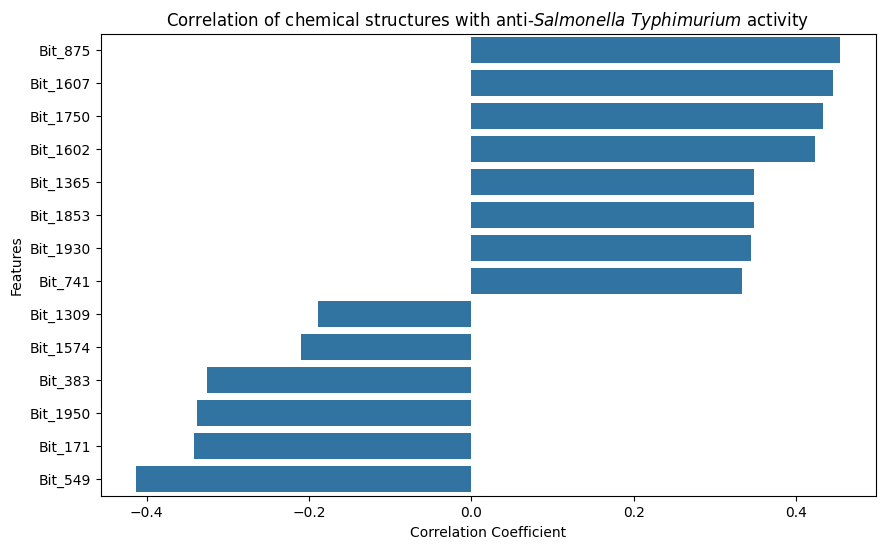

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, ExtraTreesClassifier
from sklearn.model_selection import train_test_split

#  'features_filtered', 'target_filtered', and 'indices' are already defined

# Selecting the top features for analysis
top_feature_names = features_filtered.columns[indices[:TOP_FEATURES]]

X_top_features = features_filtered[top_feature_names]
y = target_filtered

# Combine the top features and the target variable into a single DataFrame for correlation analysis
correlation_data = X_top_features.copy()
correlation_data['Target'] = y

# Calculate the correlation matrix with the target
corr_with_target = correlation_data.corr()['Target'].drop('Target').sort_values(ascending=False)

# Plotting the correlation with the target
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation of chemical structures with anti-$\it{Salmonella\ Typhimurium}$ activity')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

# Calculate the correlation matrix among top features
corr_matrix_top_features = X_top_features.corr()


In [33]:
# Export the correlation between chemical features and the target variable to a CSV file
corr_with_target.to_csv('chemical_target_correlation.csv', header=True)
print("Correlation data exported to 'chemical_target_correlation.csv'")

# Export the correlation matrix of top features to a CSV file
corr_matrix_top_features.to_csv('top_feature_correlation_matrix.csv', header=True)
print("Correlation matrix of top features exported to 'top_feature_correlation_matrix.csv'")



Correlation data exported to 'chemical_target_correlation.csv'
Correlation matrix of top features exported to 'top_feature_correlation_matrix.csv'


# removing reduntant structures created due to Morgan fingerprint hashing collisions

In [34]:
import pandas as pd
import ast  

def get_unique_structures_info(bit_name, correlation_coefficient):
    bit_file_path = f'features/{bit_name}_updated.csv'
    unique_structures_info = {}

    try:
        bit_df = pd.read_csv(bit_file_path)
        for _, row in bit_df.iterrows():
            interpretation = row['BitInterpretations']
            try:
                interpretation_list = ast.literal_eval(interpretation)
                for item in interpretation_list:
                    if len(item) == 4:
                        structure = item[3]
                        if structure not in unique_structures_info:
                            unique_structures_info[structure] = {
                                'SMILES': row['SMILES'],
                                'Chemical_name': row['Chemical_name'],
                                'Correlation_Coefficient': correlation_coefficient
                            }
            except:
                continue
    except FileNotFoundError:
        print(f"File not found: {bit_file_path}")
    except Exception as e:
        print(f"An error occurred while processing {bit_name}: {e}")

    return unique_structures_info

# Load the chemical target correlation file
chemical_correlation_file_path = 'chemical_target_correlation.csv'
chemical_correlation_df = pd.read_csv(chemical_correlation_file_path)

# Prepare a new DataFrame for merged data
merged_data = []

for index, row in chemical_correlation_df.iterrows():
    bit_name = row.iloc[0]
    correlation_coefficient = row.iloc[1]  # Get the correlation coefficient
    structures_info = get_unique_structures_info(bit_name, correlation_coefficient)
    for structure, info in structures_info.items():
        merged_data.append({
            'Bit_name': bit_name,
            'Structure': structure,
            'SMILES': info['SMILES'],
            'Chemical_name': info['Chemical_name'],
            'Correlation_Coefficient': info['Correlation_Coefficient']
        })

# Convert the merged data into a DataFrame
merged_df = pd.DataFrame(merged_data)

# Optionally, you can save this merged DataFrame to a CSV file
merged_df.to_csv('merged_chemical_data.csv', index=False)

print(merged_df.head()) 


   Bit_name Structure                    SMILES  \
0   Bit_875       ccc  CC(=O)C1=C(C=C(C=C1)OC)O   
1  Bit_1607    cc(c)O  CC(=O)C1=C(C=C(C=C1)OC)O   
2  Bit_1750       ccc        COc1ccc(\C=C\C)cc1   
3  Bit_1602        cO  CC(=O)C1=C(C=C(C=C1)OC)O   
4  Bit_1602        CO    CC(C)C1CCC(C)=C(O)C1=O   

                      Chemical_name  Correlation_Coefficient  
0  2-Hydroxy-4-methoxy-acetophenone                 0.454575  
1  2-Hydroxy-4-methoxy-acetophenone                 0.445048  
2                      (E)-Anethole                 0.433490  
3  2-Hydroxy-4-methoxy-acetophenone                 0.422843  
4                        Diosphenol                 0.422843  
